In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ipynb.fs.full.utility_functions import (
    get_price_data,
    calculate_covariance_directly,
    get_strategy_stats,
)
from datetime import datetime
from statsmodels.tsa.stattools import coint

In [7]:
univ = [
    "BTCUSDT", "ETHUSDT", "ADAUSDT", "BNBUSDT", "XRPUSDT", "DOTUSDT", "MATICUSDT", "LTCUSDT", "BCHUSDT",
    "LINKUSDT", "XLMUSDT", "USDCUSDT", "EOSUSDT", "TRXUSDT", "XTZUSDT", "FILUSDT", "NEOUSDT", "DAIUSDT",
    "DASHUSDT", "VETUSDT", "ATOMUSDT", "AAVEUSDT", "UNIUSDT", "GRTUSDT", "THETAUSDT", "IOTAUSDT", "BUSDUSDT",
    "ZECUSDT", "YFIUSDT", "ETCUSDT", "WAVESUSDT", "COMPUSDT", "SNXUSDT", "DOGEUSDT", "MKRUSDT", "ZILUSDT",
    "SUSHIUSDT", "KSMUSDT", "OMGUSDT", "ONTUSDT", "ALGOUSDT", "EGLDUSDT", "BATUSDT", "DGBUSDT", "ZRXUSDT",
    "TUSDUSDT", "QTUMUSDT", "ICXUSDT", "AVAXUSDT", "RENUSDT", "HBARUSDT", "NEARUSDT", "LRCUSDT", "CELOUSDT",
    "KNCUSDT", "LSKUSDT", "OCEANUSDT", "QNTUSDT", "USTUSDT", "BANDUSDT", "MANAUSDT", "ENJUSDT", "ANTUSDT",
    "BNTUSDT", "ZENUSDT", "NMRUSDT", "RVNUSDT", "IOSTUSDT", "OXTUSDT", "CRVUSDT", "MATICUSDT", "HNTUSDT",
    "BALUSDT", "CHZUSDT"
]

px = get_price_data(univ, '4h', True, './class_project_input_prices.csv')

In [23]:
cutoff_1 = datetime(2022, 1, 1, 0, 0)
cutoff_2 = datetime(2024, 1, 1, 0, 0)

px_2022_2024 = px.loc[cutoff_1:cutoff_2].iloc[:-1]
px_2024_2025 = px.loc[cutoff_2:]

In [13]:
def find_cointegrated_pairs(data, significance_level=0.05):
    """
    Finds cointegrated pairs using the Engle-Granger two-step method.
    Returns a list of cointegrated pairs with their p-value.
    """
    n = data.shape[1]
    keys = data.columns
    pvalue_matrix = pd.DataFrame(np.ones((n, n)), index=keys, columns=keys)
    pairs = []

    for i in range(n):
        for j in range(i + 1, n):
            series1 = data[keys[i]]
            series2 = data[keys[j]]
            
            joint_non_na_series1 = series1.loc[series1.notna() & series2.notna()]
            joint_non_na_series2 = series2.loc[series1.notna() & series2.notna()]
            
            if len(joint_non_na_series1) == 0 or len(joint_non_na_series2) == 0:
                pvalue_matrix.loc[keys[i], keys[j]] = 1.0
                continue

            # Perform the cointegration test
            score, pvalue, _ = coint(joint_non_na_series1, joint_non_na_series2)
            pvalue_matrix.loc[keys[i], keys[j]] = pvalue

            if pvalue < significance_level:
                pairs.append((keys[i], keys[j], pvalue))
    return pvalue_matrix, pairs

In [ ]:
pvalue_matrix, pairs = find_cointegrated_pairs(px_2022_2024, 1e-7)

In [101]:
def simulate_trades(px_train, strat_data, coin_1, coin_2, entry_z_score = 1.75, exit_z_score = 0.75):
    money_earned = 0.0

    shifted_forward_strat_data = strat_data.shift()

    balance_record = pd.Series()

    coin_1_share_count = 0
    coin_2_share_count = 0.0
    coin_1_position_size_change = pd.Series()
    coin_2_position_size_change = pd.Series()
    absolute_capital = pd.Series()

    # coin_1 ~ coin_2 * b + a
    # long 1 coin_1, short b coin_2

    for i in range(len(shifted_forward_strat_data)):
        open_time = shifted_forward_strat_data.index[i]
        is_currently_holding = coin_1_share_count != 0
        z_score = shifted_forward_strat_data.iloc[i]["z-score"]
        beta = shifted_forward_strat_data.iloc[i]["beta"]
        coin_1_position_size_change[open_time] = 0.0
        coin_2_position_size_change[open_time] = 0.0

        #print(f"{open_time}: {'Holding' if is_currently_holding else 'Not Holding'}")
        
        should_print = False
        #if datetime(2024, 11, 9, 16, 0) <= open_time <= datetime(2024, 11, 11, 16, 0):
        #    should_print = True
        
        if np.isnan(px_train.iloc[i][coin_1]) or np.isnan(px_train.iloc[i][coin_2]):
            balance_record[open_time] = money_earned
            continue
        elif (z_score is None or np.isnan(z_score) or np.isnan(px_train.iloc[i][coin_1]) or 
            np.isnan(px_train.iloc[i][coin_2])):
            coin_1_share_count = 0
            coin_2_share_count = 0.0
        elif z_score > entry_z_score and not is_currently_holding: # coin_1 currently overpriced, coin_2 underpriced
            coin_1_share_count = -1
            coin_2_share_count = beta
            
            #if normalize_trades:
            #    total_capital = abs(coin_1_share_count * px_train.iloc[i-1][coin_1]) + abs(coin_2_share_count * px_train.iloc[i-1][coin_2])
            #    coin_1_share_count = coin_1_share_count / total_capital
            #    coin_2_share_count = coin_2_s
            
            coin_1_position_size_change[open_time] -= (coin_1_share_count * px_train.iloc[i-1][coin_1])
            coin_2_position_size_change[open_time] -= (coin_2_share_count * px_train.iloc[i-1][coin_2])
            
            money_earned -= (coin_1_share_count * px_train.iloc[i-1][coin_1] + coin_2_share_count * px_train.iloc[i-1][coin_2])
        elif z_score < -entry_z_score and not is_currently_holding: # coin_1 currently underpriced, coin_2 overpriced
            coin_1_share_count = +1
            coin_2_share_count = -beta
            
            coin_1_position_size_change[open_time] -= (coin_1_share_count * px_train.iloc[i-1][coin_1])
            coin_2_position_size_change[open_time] -= (coin_2_share_count * px_train.iloc[i-1][coin_2])
            
            money_earned -= (coin_1_share_count * px_train.iloc[i-1][coin_1] + coin_2_share_count * px_train.iloc[i-1][coin_2])
        elif (coin_1_share_count == -1 and z_score < exit_z_score) or (coin_1_share_count == 1 and z_score > -exit_z_score):
            
            coin_1_position_size_change[open_time] += (coin_1_share_count * px_train.iloc[i-1][coin_1])
            coin_2_position_size_change[open_time] += (coin_2_share_count * px_train.iloc[i-1][coin_2])
            
            money_earned += coin_1_share_count * px_train.iloc[i-1][coin_1] + coin_2_share_count * px_train.iloc[i-1][coin_2]
            coin_1_share_count = 0
            coin_2_share_count = 0.0

        # current_position is at the end of the interval corresponding to row i
        current_position = coin_1_share_count * px_train.iloc[i][coin_1] + coin_2_share_count * px_train.iloc[i][coin_2]
        balance_record[open_time] = money_earned + current_position
        
        if should_print:
            print(f"Time: {open_time}")
            print(f"{coin_1} share count: {coin_1_share_count}")
            print(f"{coin_2} share count: {coin_2_share_count}")
            print(f"{coin_1} price at period open: {px_train.iloc[i-1][coin_1]}")
            print(f"{coin_2} price at period open: {px_train.iloc[i-1][coin_2]}")
            print(f"{coin_1} price at period close: {px_train.iloc[i][coin_1]}")
            print(f"{coin_2} price at period close: {px_train.iloc[i][coin_2]}")
            print(f"current position: {current_position}")
            print(f"balance record: {balance_record[open_time]}")
            print(f"Price data open time: {px_train.index[i]}\n")
            
    coin_position_size_changes = {
        coin_1: coin_1_position_size_change,
        coin_2: coin_2_position_size_change,
    }

    return balance_record, coin_position_size_changes

In [25]:
def calculate_spread_strat_data(px_train, coin_1, coin_2, step, avg_z_score_window):
    strat_data = pd.DataFrame()

    spread_data = pd.Series()
    beta_data = pd.Series()

    for index in range(step):
        spread_data[px_train.index[index]] = np.nan
        beta_data[px_train.index[index]] = np.nan

    for index in range(step, len(px_train)):
        coin_1_prices = px_train.iloc[(index-step+1):(index+1)][coin_1]
        coin_2_prices = px_train.iloc[(index-step+1):(index+1)][coin_2]
        calculated_cov = calculate_covariance_directly(coin_1_prices, coin_2_prices)

        beta = calculated_cov / coin_2_prices.var()

        spread = px_train.iloc[index][coin_1] - beta * px_train.iloc[index][coin_2]
        spread_data[px_train.index[index]] = spread
        beta_data[px_train.index[index]] = beta

    strat_data["spread"] = spread_data
    strat_data["beta"] = beta_data
    
    z_score = (strat_data["spread"] - strat_data["spread"].rolling(avg_z_score_window).mean()) / strat_data["spread"].rolling(avg_z_score_window).std()
    strat_data["z-score"] = z_score
    
    return strat_data

In [27]:
beta_calculation_window = 6 * 7 * 20
z_score_avg_calculation_window = 6 * 7 * 10

In [52]:
stats_results = dict()

for beta_calculation_window in [6 * 7 * 20, 6 * 7 * 10, 6 * 7 * 5]:
    for z_score_avg_calculation_window in [6 * 7 * 20, 6 * 7 * 10, 6 * 7 * 5]:

        coint_pairs_to_balance = dict()
        position_size_changes = dict()

        for index, (coin_1, coin_2, z_score) in enumerate(pairs):
            strat_data = calculate_spread_strat_data(
                px_2024_2025,
                coin_1,
                coin_2,
                beta_calculation_window,
                z_score_avg_calculation_window
            )

            single_pair_gross_balance, single_pair_position_size_changes = simulate_trades(
                px_2024_2025, strat_data, coin_1, coin_2)
            coint_pairs_to_balance[(coin_1, coin_2)] = single_pair_gross_balance

            for coin in (coin_1, coin_2):
                if coin in position_size_changes:
                    position_size_changes[coin] = position_size_changes[coin] + single_pair_position_size_changes[coin]
                else:
                    position_size_changes[coin] = single_pair_position_size_changes[coin]

            print(f"{index+1} / {len(pairs)}")

        total_gross_positions = sum(coint_pairs_to_balance.values())

        raw_gross_returns = total_gross_positions / total_gross_positions.shift() - 1
        gross_returns = raw_gross_returns[~(
            np.isnan(raw_gross_returns) | (raw_gross_returns == float('inf')) | (raw_gross_returns == float('-inf'))
        )]

        position_size_changes_df = pd.DataFrame(position_size_changes)
        turnover = position_size_changes_df.loc[gross_returns.index].abs().sum(axis=1)
        tcost_bps = 20
        net_returns = gross_returns.subtract(turnover * tcost_bps * 1e-4, fill_value = 0)
        stats_results[(beta_calculation_window, z_score_avg_calculation_window)] = get_strategy_stats(
            net_returns, 4, px.loc[net_returns.index]
        )

1 / 75
2 / 75
3 / 75
4 / 75
5 / 75
6 / 75
7 / 75
8 / 75
9 / 75
10 / 75
11 / 75
12 / 75
13 / 75
14 / 75
15 / 75
16 / 75
17 / 75
18 / 75
19 / 75
20 / 75
21 / 75
22 / 75
23 / 75
24 / 75
25 / 75
26 / 75
27 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/

28 / 75
29 / 75
30 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


31 / 75
32 / 75
33 / 75
34 / 75
35 / 75
36 / 75
37 / 75
38 / 75
39 / 75
40 / 75
41 / 75
42 / 75
43 / 75
44 / 75
45 / 75
46 / 75
47 / 75
48 / 75
49 / 75
50 / 75
51 / 75
52 / 75
53 / 75
54 / 75
55 / 75
56 / 75
57 / 75
58 / 75
59 / 75
60 / 75
61 / 75
62 / 75
63 / 75
64 / 75
65 / 75
66 / 75
67 / 75
68 / 75
69 / 75
70 / 75
71 / 75
72 / 75
73 / 75
74 / 75
75 / 75
1 / 75
2 / 75
3 / 75
4 / 75
5 / 75
6 / 75
7 / 75
8 / 75
9 / 75
10 / 75
11 / 75
12 / 75
13 / 75
14 / 75
15 / 75
16 / 75
17 / 75
18 / 75
19 / 75
20 / 75
21 / 75
22 / 75
23 / 75
24 / 75
25 / 75
26 / 75
27 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/

28 / 75
29 / 75
30 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


31 / 75
32 / 75
33 / 75
34 / 75
35 / 75
36 / 75
37 / 75
38 / 75
39 / 75
40 / 75
41 / 75
42 / 75
43 / 75
44 / 75
45 / 75
46 / 75
47 / 75
48 / 75
49 / 75
50 / 75
51 / 75
52 / 75
53 / 75
54 / 75
55 / 75
56 / 75
57 / 75
58 / 75
59 / 75
60 / 75
61 / 75
62 / 75
63 / 75
64 / 75
65 / 75
66 / 75
67 / 75
68 / 75
69 / 75
70 / 75
71 / 75
72 / 75
73 / 75
74 / 75
75 / 75
1 / 75
2 / 75
3 / 75
4 / 75
5 / 75
6 / 75
7 / 75
8 / 75
9 / 75
10 / 75
11 / 75
12 / 75
13 / 75
14 / 75
15 / 75
16 / 75
17 / 75
18 / 75
19 / 75
20 / 75
21 / 75
22 / 75
23 / 75
24 / 75
25 / 75
26 / 75
27 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/

28 / 75
29 / 75
30 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


31 / 75
32 / 75
33 / 75
34 / 75
35 / 75
36 / 75
37 / 75
38 / 75
39 / 75
40 / 75
41 / 75
42 / 75
43 / 75
44 / 75
45 / 75
46 / 75
47 / 75
48 / 75
49 / 75
50 / 75
51 / 75
52 / 75
53 / 75
54 / 75
55 / 75
56 / 75
57 / 75
58 / 75
59 / 75
60 / 75
61 / 75
62 / 75
63 / 75
64 / 75
65 / 75
66 / 75
67 / 75
68 / 75
69 / 75
70 / 75
71 / 75
72 / 75
73 / 75
74 / 75
75 / 75
1 / 75
2 / 75
3 / 75
4 / 75
5 / 75
6 / 75
7 / 75
8 / 75
9 / 75
10 / 75
11 / 75
12 / 75
13 / 75
14 / 75
15 / 75
16 / 75
17 / 75
18 / 75
19 / 75
20 / 75
21 / 75
22 / 75
23 / 75
24 / 75
25 / 75
26 / 75
27 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/

28 / 75
29 / 75
30 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


31 / 75
32 / 75
33 / 75
34 / 75
35 / 75
36 / 75
37 / 75
38 / 75
39 / 75
40 / 75
41 / 75
42 / 75
43 / 75
44 / 75
45 / 75
46 / 75
47 / 75
48 / 75
49 / 75
50 / 75
51 / 75
52 / 75
53 / 75
54 / 75
55 / 75
56 / 75
57 / 75
58 / 75
59 / 75
60 / 75
61 / 75
62 / 75
63 / 75
64 / 75
65 / 75
66 / 75
67 / 75
68 / 75
69 / 75
70 / 75
71 / 75
72 / 75
73 / 75
74 / 75
75 / 75
1 / 75
2 / 75
3 / 75
4 / 75
5 / 75
6 / 75
7 / 75
8 / 75
9 / 75
10 / 75
11 / 75
12 / 75
13 / 75
14 / 75
15 / 75
16 / 75
17 / 75
18 / 75
19 / 75
20 / 75
21 / 75
22 / 75
23 / 75
24 / 75
25 / 75
26 / 75
27 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/

28 / 75
29 / 75
30 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


31 / 75
32 / 75
33 / 75
34 / 75
35 / 75
36 / 75
37 / 75
38 / 75
39 / 75
40 / 75
41 / 75
42 / 75
43 / 75
44 / 75
45 / 75
46 / 75
47 / 75
48 / 75
49 / 75
50 / 75
51 / 75
52 / 75
53 / 75
54 / 75
55 / 75
56 / 75
57 / 75
58 / 75
59 / 75
60 / 75
61 / 75
62 / 75
63 / 75
64 / 75
65 / 75
66 / 75
67 / 75
68 / 75
69 / 75
70 / 75
71 / 75
72 / 75
73 / 75
74 / 75
75 / 75
1 / 75
2 / 75
3 / 75
4 / 75
5 / 75
6 / 75
7 / 75
8 / 75
9 / 75
10 / 75
11 / 75
12 / 75
13 / 75
14 / 75
15 / 75
16 / 75
17 / 75
18 / 75
19 / 75
20 / 75
21 / 75
22 / 75
23 / 75
24 / 75
25 / 75
26 / 75
27 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/

28 / 75
29 / 75
30 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


31 / 75
32 / 75
33 / 75
34 / 75
35 / 75
36 / 75
37 / 75
38 / 75
39 / 75
40 / 75
41 / 75
42 / 75
43 / 75
44 / 75
45 / 75
46 / 75
47 / 75
48 / 75
49 / 75
50 / 75
51 / 75
52 / 75
53 / 75
54 / 75
55 / 75
56 / 75
57 / 75
58 / 75
59 / 75
60 / 75
61 / 75
62 / 75
63 / 75
64 / 75
65 / 75
66 / 75
67 / 75
68 / 75
69 / 75
70 / 75
71 / 75
72 / 75
73 / 75
74 / 75
75 / 75
1 / 75
2 / 75
3 / 75
4 / 75
5 / 75
6 / 75
7 / 75
8 / 75
9 / 75
10 / 75
11 / 75
12 / 75
13 / 75
14 / 75
15 / 75
16 / 75
17 / 75
18 / 75
19 / 75
20 / 75
21 / 75
22 / 75
23 / 75
24 / 75
25 / 75
26 / 75
27 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/

28 / 75
29 / 75
30 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


31 / 75
32 / 75
33 / 75
34 / 75
35 / 75
36 / 75
37 / 75
38 / 75
39 / 75
40 / 75
41 / 75
42 / 75
43 / 75
44 / 75
45 / 75
46 / 75
47 / 75
48 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1

49 / 75
50 / 75
51 / 75
52 / 75
53 / 75
54 / 75
55 / 75
56 / 75
57 / 75
58 / 75
59 / 75
60 / 75
61 / 75
62 / 75
63 / 75
64 / 75
65 / 75
66 / 75
67 / 75
68 / 75
69 / 75
70 / 75
71 / 75
72 / 75
73 / 75
74 / 75
75 / 75
1 / 75
2 / 75
3 / 75
4 / 75
5 / 75
6 / 75
7 / 75
8 / 75
9 / 75
10 / 75
11 / 75
12 / 75
13 / 75
14 / 75
15 / 75
16 / 75
17 / 75
18 / 75
19 / 75
20 / 75
21 / 75
22 / 75
23 / 75
24 / 75
25 / 75
26 / 75
27 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/

28 / 75
29 / 75
30 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


31 / 75
32 / 75
33 / 75
34 / 75
35 / 75
36 / 75
37 / 75
38 / 75
39 / 75
40 / 75
41 / 75
42 / 75
43 / 75
44 / 75
45 / 75
46 / 75
47 / 75
48 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1

49 / 75
50 / 75
51 / 75
52 / 75
53 / 75
54 / 75
55 / 75
56 / 75
57 / 75
58 / 75
59 / 75
60 / 75
61 / 75
62 / 75
63 / 75
64 / 75
65 / 75
66 / 75
67 / 75
68 / 75
69 / 75
70 / 75
71 / 75
72 / 75
73 / 75
74 / 75
75 / 75
1 / 75
2 / 75
3 / 75
4 / 75
5 / 75
6 / 75
7 / 75
8 / 75
9 / 75
10 / 75
11 / 75
12 / 75
13 / 75
14 / 75
15 / 75
16 / 75
17 / 75
18 / 75
19 / 75
20 / 75
21 / 75
22 / 75
23 / 75
24 / 75
25 / 75
26 / 75
27 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/

28 / 75
29 / 75
30 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


31 / 75
32 / 75
33 / 75
34 / 75
35 / 75
36 / 75
37 / 75
38 / 75
39 / 75
40 / 75
41 / 75
42 / 75
43 / 75
44 / 75
45 / 75
46 / 75
47 / 75
48 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1

49 / 75
50 / 75
51 / 75
52 / 75
53 / 75
54 / 75
55 / 75
56 / 75
57 / 75
58 / 75
59 / 75
60 / 75
61 / 75
62 / 75
63 / 75
64 / 75
65 / 75
66 / 75
67 / 75
68 / 75
69 / 75
70 / 75
71 / 75
72 / 75
73 / 75
74 / 75
75 / 75


In [56]:
pd.DataFrame(stats_results).T.sort_values('sharpe ratio', ascending=False)

avg returns  decorrelated avg returns  volatility  sharpe ratio  \
210 840    43.608289                 42.899094   43.563759      1.001022   
840 210   149.836471                151.113087  178.623255      0.838841   
    840     8.124993                  8.490326   11.593294      0.700836   
    420    20.754943                 32.143729   42.562565      0.487634   
420 840  -204.110492               -215.174679  238.611740     -0.855408   
210 210   -91.791983                 -5.787913  104.569118     -0.877812   
    420   -52.637693                -54.721340   49.821068     -1.056535   
420 210   -17.332929                -17.977466   13.243917     -1.308746   
    420   -27.140832                -13.399019   18.238644     -1.488095   

         decorrelated sharpe ratio  max drawdown  max drawdown duration  \
210 840                   0.984919     -0.060454             396.000000   
840 210                   0.845865     -4.232973             418.000000   
    840                   0.732301     -1.924871             298.166667   
    420                   0.784324     -0.342278             355.333333   
420 840                  -0.903499     -7.734473             397.666667   
210 210                  -0.869737      0.000000             538.000000   
    420                  -1.102263    -20.168997             503.166667   
420 210                  -1.358540   -334.525264             503.000000   
    420                  -1.396791      0.000000             458.166667   

         alpha_BTC  beta_BTC  
210 840   0.020282  2.042394  
840 210   0.069121 -3.332889  
    840   0.003636 -0.232966  
    420   0.014909 -0.699765  
420 840  -0.098078 -6.640724  
210 210  -0.002810 -0.194351  
    420  -0.024981 -2.922590  
420 210  -0.005351  0.708544  
    420  -0.006011 -0.084330

In [57]:
beta_calculation_window = 210
z_score_avg_calculation_window = 840

coint_pairs_to_balance = dict()
position_size_changes = dict()

for index, (coin_1, coin_2, z_score) in enumerate(pairs):
    strat_data = calculate_spread_strat_data(
        px_2024_2025,
        coin_1,
        coin_2,
        beta_calculation_window,
        z_score_avg_calculation_window
    )

    single_pair_gross_balance, single_pair_position_size_changes = simulate_trades(
        px_2024_2025, strat_data, coin_1, coin_2)
    coint_pairs_to_balance[(coin_1, coin_2)] = single_pair_gross_balance

    for coin in (coin_1, coin_2):
        if coin in position_size_changes:
            position_size_changes[coin] = position_size_changes[coin] + single_pair_position_size_changes[coin]
        else:
            position_size_changes[coin] = single_pair_position_size_changes[coin]

    print(f"{index+1} / {len(pairs)}")

total_gross_positions = sum(coint_pairs_to_balance.values())

raw_gross_returns = total_gross_positions / total_gross_positions.shift() - 1
gross_returns = raw_gross_returns[~(
    np.isnan(raw_gross_returns) | (raw_gross_returns == float('inf')) | (raw_gross_returns == float('-inf'))
)]

position_size_changes_df = pd.DataFrame(position_size_changes)
turnover = position_size_changes_df.loc[gross_returns.index].abs().sum(axis=1)
tcost_bps = 20
net_returns = gross_returns.subtract(turnover * tcost_bps * 1e-4, fill_value = 0)
stats = get_strategy_stats(net_returns, 4, px.loc[net_returns.index])

1 / 75
2 / 75
3 / 75
4 / 75
5 / 75
6 / 75
7 / 75
8 / 75
9 / 75
10 / 75
11 / 75
12 / 75
13 / 75
14 / 75
15 / 75
16 / 75
17 / 75
18 / 75
19 / 75
20 / 75
21 / 75
22 / 75
23 / 75
24 / 75
25 / 75
26 / 75
27 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/

28 / 75
29 / 75
30 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


31 / 75
32 / 75
33 / 75
34 / 75
35 / 75
36 / 75
37 / 75
38 / 75
39 / 75
40 / 75
41 / 75
42 / 75
43 / 75
44 / 75
45 / 75
46 / 75
47 / 75
48 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1

49 / 75
50 / 75
51 / 75
52 / 75
53 / 75
54 / 75
55 / 75
56 / 75
57 / 75
58 / 75
59 / 75
60 / 75
61 / 75
62 / 75
63 / 75
64 / 75
65 / 75
66 / 75
67 / 75
68 / 75
69 / 75
70 / 75
71 / 75
72 / 75
73 / 75
74 / 75
75 / 75


In [58]:
stats

{'avg returns': 43.60828861455236,
 'decorrelated avg returns': 42.89909418604774,
 'volatility': 43.563759325847556,
 'sharpe ratio': 1.0010221635917997,
 'decorrelated sharpe ratio': 0.9849194039434083,
 'max drawdown': -0.06045394050273567,
 'max drawdown duration': 396.0,
 'alpha_BTC': 0.02028166813998468,
 'beta_BTC': 2.042393578809662}

<Axes: >

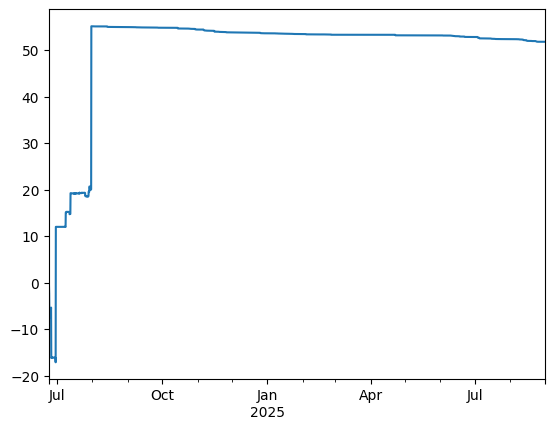

In [60]:
net_returns.cumsum().plot()

In [61]:
beta_calculation_window = 840
z_score_avg_calculation_window = 210

coint_pairs_to_balance = dict()
position_size_changes = dict()

for index, (coin_1, coin_2, z_score) in enumerate(pairs):
    strat_data = calculate_spread_strat_data(
        px_2024_2025,
        coin_1,
        coin_2,
        beta_calculation_window,
        z_score_avg_calculation_window
    )

    single_pair_gross_balance, single_pair_position_size_changes = simulate_trades(
        px_2024_2025, strat_data, coin_1, coin_2)
    coint_pairs_to_balance[(coin_1, coin_2)] = single_pair_gross_balance

    for coin in (coin_1, coin_2):
        if coin in position_size_changes:
            position_size_changes[coin] = position_size_changes[coin] + single_pair_position_size_changes[coin]
        else:
            position_size_changes[coin] = single_pair_position_size_changes[coin]

    print(f"{index+1} / {len(pairs)}")

total_gross_positions = sum(coint_pairs_to_balance.values())

raw_gross_returns = total_gross_positions / total_gross_positions.shift() - 1
gross_returns = raw_gross_returns[~(
    np.isnan(raw_gross_returns) | (raw_gross_returns == float('inf')) | (raw_gross_returns == float('-inf'))
)]

position_size_changes_df = pd.DataFrame(position_size_changes)
turnover = position_size_changes_df.loc[gross_returns.index].abs().sum(axis=1)
tcost_bps = 20
net_returns = gross_returns.subtract(turnover * tcost_bps * 1e-4, fill_value = 0)
stats = get_strategy_stats(net_returns, 4, px.loc[net_returns.index])

1 / 75
2 / 75
3 / 75
4 / 75
5 / 75
6 / 75
7 / 75
8 / 75
9 / 75
10 / 75
11 / 75
12 / 75
13 / 75
14 / 75
15 / 75
16 / 75
17 / 75
18 / 75
19 / 75
20 / 75
21 / 75
22 / 75
23 / 75
24 / 75
25 / 75
26 / 75
27 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/

28 / 75
29 / 75
30 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


31 / 75
32 / 75
33 / 75
34 / 75
35 / 75
36 / 75
37 / 75
38 / 75
39 / 75
40 / 75
41 / 75
42 / 75
43 / 75
44 / 75
45 / 75
46 / 75
47 / 75
48 / 75
49 / 75
50 / 75
51 / 75
52 / 75
53 / 75
54 / 75
55 / 75
56 / 75
57 / 75
58 / 75
59 / 75
60 / 75
61 / 75
62 / 75
63 / 75
64 / 75
65 / 75
66 / 75
67 / 75
68 / 75
69 / 75
70 / 75
71 / 75
72 / 75
73 / 75
74 / 75
75 / 75


<Axes: >

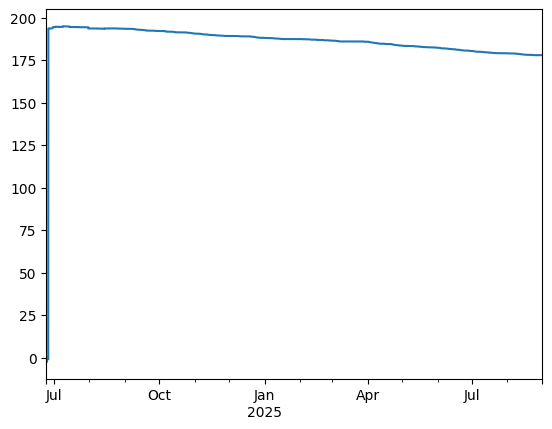

In [63]:
net_returns.cumsum().plot()

# Trade Freq = 8h
# Calculate Z-Scores During 2024-2025
# Entry Z-Score = 1.75, Exit Z-Score = 0.75

In [65]:
beta_calculation_window = 210
z_score_avg_calculation_window = 840

start_time = datetime(2024, 1, 1, 0, 0)
end_time = px.index[-1]
px_8h = px.loc[pd.date_range(start_time, end_time, freq='8h')]

coint_pairs_to_balance = dict()
position_size_changes = dict()

for index, (coin_1, coin_2, z_score) in enumerate(pairs):
    strat_data = calculate_spread_strat_data(
        px_8h,
        coin_1,
        coin_2,
        beta_calculation_window,
        z_score_avg_calculation_window
    )

    single_pair_gross_balance, single_pair_position_size_changes = simulate_trades(
        px_8h, strat_data, coin_1, coin_2)
    coint_pairs_to_balance[(coin_1, coin_2)] = single_pair_gross_balance

    for coin in (coin_1, coin_2):
        if coin in position_size_changes:
            position_size_changes[coin] = position_size_changes[coin] + single_pair_position_size_changes[coin]
        else:
            position_size_changes[coin] = single_pair_position_size_changes[coin]

    print(f"{index+1} / {len(pairs)}")

total_gross_positions = sum(coint_pairs_to_balance.values())

raw_gross_returns = total_gross_positions / total_gross_positions.shift() - 1
gross_returns = raw_gross_returns[~(
    np.isnan(raw_gross_returns) | (raw_gross_returns == float('inf')) | (raw_gross_returns == float('-inf'))
)]

position_size_changes_df = pd.DataFrame(position_size_changes)
turnover = position_size_changes_df.loc[gross_returns.index].abs().sum(axis=1)
tcost_bps = 20
net_returns = gross_returns.subtract(turnover * tcost_bps * 1e-4, fill_value = 0)
stats = get_strategy_stats(net_returns, 8, px.loc[net_returns.index])

1 / 75
2 / 75
3 / 75
4 / 75
5 / 75
6 / 75
7 / 75
8 / 75
9 / 75
10 / 75
11 / 75
12 / 75
13 / 75
14 / 75
15 / 75
16 / 75
17 / 75
18 / 75
19 / 75
20 / 75
21 / 75
22 / 75
23 / 75
24 / 75
25 / 75
26 / 75
27 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


28 / 75
29 / 75
30 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


31 / 75
32 / 75
33 / 75
34 / 75
35 / 75
36 / 75
37 / 75
38 / 75
39 / 75
40 / 75
41 / 75
42 / 75
43 / 75
44 / 75
45 / 75
46 / 75
47 / 75
48 / 75
49 / 75
50 / 75
51 / 75
52 / 75
53 / 75
54 / 75
55 / 75
56 / 75
57 / 75
58 / 75
59 / 75
60 / 75
61 / 75
62 / 75
63 / 75
64 / 75
65 / 75
66 / 75
67 / 75
68 / 75
69 / 75
70 / 75
71 / 75
72 / 75
73 / 75
74 / 75
75 / 75


In [66]:
stats

{'avg returns': -27.05942326525682,
 'decorrelated avg returns': -24.10186475320693,
 'volatility': 25.931730954920866,
 'sharpe ratio': -1.0434869663076602,
 'decorrelated sharpe ratio': -0.9336034625985553,
 'max drawdown': 0.0,
 'max drawdown duration': 254.66666666666666,
 'alpha_BTC': 0.0058164836724295685,
 'beta_BTC': 0.5036907234277284}

<Axes: >

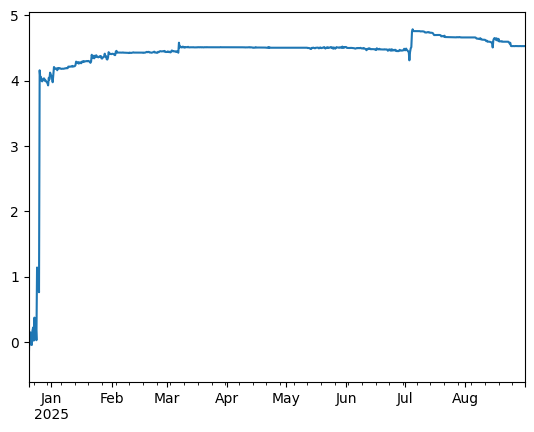

In [70]:
net_returns.iloc[2:].cumsum().plot()

In [72]:
net_returns_mod = net_returns.iloc[2:]
net_returns_mod.mean() / net_returns_mod.std() * np.sqrt(365 * 3)

1.4574982675067312

# Trade Freq = 8h
# Calculate Z-Scores During 2022-2025
# Entry Z-Score = 1.75, Exit Z-Score = 0.75

In [76]:
pd.date_range(start_2022_time, end_time, freq='8h').drop(datetime(2023, 2, 6, 8, 0))

DatetimeIndex(['2022-01-01 00:00:00', '2022-01-01 08:00:00',
               '2022-01-01 16:00:00', '2022-01-02 00:00:00',
               '2022-01-02 08:00:00', '2022-01-02 16:00:00',
               '2022-01-03 00:00:00', '2022-01-03 08:00:00',
               '2022-01-03 16:00:00', '2022-01-04 00:00:00',
               ...
               '2025-08-28 08:00:00', '2025-08-28 16:00:00',
               '2025-08-29 00:00:00', '2025-08-29 08:00:00',
               '2025-08-29 16:00:00', '2025-08-30 00:00:00',
               '2025-08-30 08:00:00', '2025-08-30 16:00:00',
               '2025-08-31 00:00:00', '2025-08-31 08:00:00'],
              dtype='datetime64[ns]', length=4015, freq=None)

In [78]:
beta_calculation_window = 210
z_score_avg_calculation_window = 840

start_2022_time = datetime(2022, 1, 1, 0, 0)
start_time = datetime(2024, 1, 1, 0, 0)
end_time = px.index[-1]
px_2022_8h = px.loc[pd.date_range(start_2022_time, end_time, freq='8h').drop(datetime(2023, 2, 6, 8, 0))]
px_2024_8h = px.loc[pd.date_range(start_time, end_time, freq='8h')]

coint_pairs_to_balance = dict()
position_size_changes = dict()

for index, (coin_1, coin_2, z_score) in enumerate(pairs):
    strat_data = calculate_spread_strat_data(
        px_2022_8h,
        coin_1,
        coin_2,
        beta_calculation_window,
        z_score_avg_calculation_window
    )

    single_pair_gross_balance, single_pair_position_size_changes = simulate_trades(
        px_2024_8h, strat_data.loc[start_time:], coin_1, coin_2)
    coint_pairs_to_balance[(coin_1, coin_2)] = single_pair_gross_balance

    for coin in (coin_1, coin_2):
        if coin in position_size_changes:
            position_size_changes[coin] = position_size_changes[coin] + single_pair_position_size_changes[coin]
        else:
            position_size_changes[coin] = single_pair_position_size_changes[coin]

    print(f"{index+1} / {len(pairs)}")

total_gross_positions = sum(coint_pairs_to_balance.values())

raw_gross_returns = total_gross_positions / total_gross_positions.shift() - 1
gross_returns = raw_gross_returns[~(
    np.isnan(raw_gross_returns) | (raw_gross_returns == float('inf')) | (raw_gross_returns == float('-inf'))
)]

position_size_changes_df = pd.DataFrame(position_size_changes)
turnover = position_size_changes_df.loc[gross_returns.index].abs().sum(axis=1)
tcost_bps = 20
net_returns = gross_returns.subtract(turnover * tcost_bps * 1e-4, fill_value = 0)
stats = get_strategy_stats(net_returns, 8, px.loc[net_returns.index])

1 / 75
2 / 75
3 / 75
4 / 75
5 / 75
6 / 75
7 / 75
8 / 75
9 / 75
10 / 75
11 / 75
12 / 75
13 / 75
14 / 75
15 / 75
16 / 75
17 / 75
18 / 75
19 / 75
20 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


21 / 75
22 / 75
23 / 75
24 / 75
25 / 75
26 / 75
27 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


28 / 75
29 / 75
30 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


31 / 75
32 / 75
33 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


34 / 75
35 / 75
36 / 75
37 / 75
38 / 75
39 / 75
40 / 75
41 / 75
42 / 75
43 / 75
44 / 75
45 / 75
46 / 75
47 / 75
48 / 75
49 / 75
50 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


51 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


52 / 75
53 / 75
54 / 75
55 / 75
56 / 75
57 / 75
58 / 75
59 / 75
60 / 75
61 / 75
62 / 75
63 / 75
64 / 75
65 / 75
66 / 75
67 / 75
68 / 75
69 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


70 / 75
71 / 75
72 / 75
73 / 75
74 / 75
75 / 75


In [79]:
stats

{'avg returns': 126.77485900234439,
 'decorrelated avg returns': 126.28544231889305,
 'volatility': 122.3943560861963,
 'sharpe ratio': 1.03579007281237,
 'decorrelated sharpe ratio': 1.031542980805683,
 'max drawdown': -3.5526903540191044,
 'max drawdown duration': 573.3333333333334,
 'alpha_BTC': 0.11491709637941461,
 'beta_BTC': 1.4066704486042638}

<Axes: >

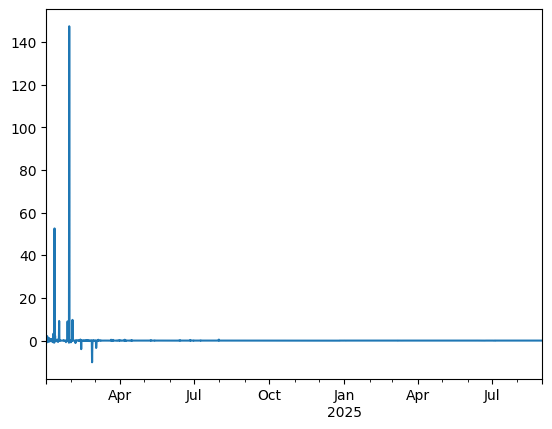

In [82]:
net_returns.plot()

# Trade Freq = 8h
# Calculate Z-Scores During 2022-2025
# Entry Z-Score = 1.75, Exit Z-Score = 0.75
# Beta calculation window = 3 * 7
# Z-score calculation window = 3 * 7 * 4

In [83]:
beta_calculation_window = 3 * 7
z_score_avg_calculation_window = 3 * 7 * 4

start_2022_time = datetime(2022, 1, 1, 0, 0)
start_time = datetime(2024, 1, 1, 0, 0)
end_time = px.index[-1]
px_2022_8h = px.loc[pd.date_range(start_2022_time, end_time, freq='8h').drop(datetime(2023, 2, 6, 8, 0))]
px_2024_8h = px.loc[pd.date_range(start_time, end_time, freq='8h')]

coint_pairs_to_balance = dict()
position_size_changes = dict()

for index, (coin_1, coin_2, z_score) in enumerate(pairs):
    strat_data = calculate_spread_strat_data(
        px_2022_8h,
        coin_1,
        coin_2,
        beta_calculation_window,
        z_score_avg_calculation_window
    )

    single_pair_gross_balance, single_pair_position_size_changes = simulate_trades(
        px_2024_8h, strat_data.loc[start_time:], coin_1, coin_2)
    coint_pairs_to_balance[(coin_1, coin_2)] = single_pair_gross_balance

    for coin in (coin_1, coin_2):
        if coin in position_size_changes:
            position_size_changes[coin] = position_size_changes[coin] + single_pair_position_size_changes[coin]
        else:
            position_size_changes[coin] = single_pair_position_size_changes[coin]

    print(f"{index+1} / {len(pairs)}")

total_gross_positions = sum(coint_pairs_to_balance.values())

raw_gross_returns = total_gross_positions / total_gross_positions.shift() - 1
gross_returns = raw_gross_returns[~(
    np.isnan(raw_gross_returns) | (raw_gross_returns == float('inf')) | (raw_gross_returns == float('-inf'))
)]

position_size_changes_df = pd.DataFrame(position_size_changes)
turnover = position_size_changes_df.loc[gross_returns.index].abs().sum(axis=1)
tcost_bps = 20
net_returns = gross_returns.subtract(turnover * tcost_bps * 1e-4, fill_value = 0)
stats = get_strategy_stats(net_returns, 8, px.loc[net_returns.index])

1 / 75
2 / 75
3 / 75
4 / 75
5 / 75
6 / 75
7 / 75
8 / 75
9 / 75
10 / 75
11 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


12 / 75
13 / 75
14 / 75
15 / 75
16 / 75
17 / 75
18 / 75
19 / 75
20 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


21 / 75
22 / 75
23 / 75
24 / 75
25 / 75
26 / 75
27 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1

28 / 75
29 / 75
30 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


31 / 75
32 / 75
33 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


34 / 75
35 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


36 / 75
37 / 75
38 / 75
39 / 75
40 / 75
41 / 75
42 / 75
43 / 75
44 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


45 / 75
46 / 75
47 / 75
48 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1

49 / 75
50 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


51 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


52 / 75
53 / 75
54 / 75
55 / 75
56 / 75
57 / 75
58 / 75
59 / 75
60 / 75
61 / 75
62 / 75
63 / 75
64 / 75
65 / 75
66 / 75
67 / 75
68 / 75
69 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


70 / 75
71 / 75
72 / 75
73 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


74 / 75
75 / 75


In [84]:
stats

{'avg returns': -2.7687767888658743,
 'decorrelated avg returns': -7.3183356954025935,
 'volatility': 8.900146283353372,
 'sharpe ratio': -0.3110934023685129,
 'decorrelated sharpe ratio': -1.0285512524996718,
 'max drawdown': -1.5989372035098803,
 'max drawdown duration': 607.0,
 'alpha_BTC': -0.006888943645303576,
 'beta_BTC': 0.5618069361465933}

<Axes: >

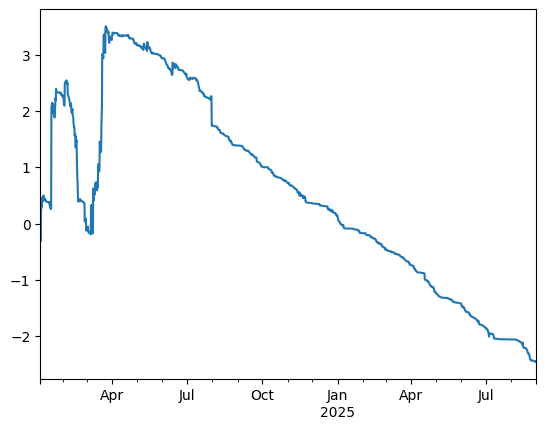

In [91]:
net_returns.iloc[7:].cumsum().plot()

In [92]:
net_returns.iloc[7:].mean() / net_returns.iloc[7:].std() * np.sqrt(365 * 3)

-0.6607089601357954

# Trade Freq = 8h
# Calculate Z-Scores During 2022-2025
# Entry Z-Score = 1.75, Exit Z-Score = 0.75
# Beta calculation window = 3 * 7 * 2
# Z-score calculation window = 3 * 7 * 8

In [93]:
beta_calculation_window = 3 * 7 * 2
z_score_avg_calculation_window = 3 * 7 * 8

start_2022_time = datetime(2022, 1, 1, 0, 0)
start_time = datetime(2024, 1, 1, 0, 0)
end_time = px.index[-1]
px_2022_8h = px.loc[pd.date_range(start_2022_time, end_time, freq='8h').drop(datetime(2023, 2, 6, 8, 0))]
px_2024_8h = px.loc[pd.date_range(start_time, end_time, freq='8h')]

coint_pairs_to_balance = dict()
position_size_changes = dict()

for index, (coin_1, coin_2, z_score) in enumerate(pairs):
    strat_data = calculate_spread_strat_data(
        px_2022_8h,
        coin_1,
        coin_2,
        beta_calculation_window,
        z_score_avg_calculation_window
    )

    single_pair_gross_balance, single_pair_position_size_changes = simulate_trades(
        px_2024_8h, strat_data.loc[start_time:], coin_1, coin_2)
    coint_pairs_to_balance[(coin_1, coin_2)] = single_pair_gross_balance

    for coin in (coin_1, coin_2):
        if coin in position_size_changes:
            position_size_changes[coin] = position_size_changes[coin] + single_pair_position_size_changes[coin]
        else:
            position_size_changes[coin] = single_pair_position_size_changes[coin]

    print(f"{index+1} / {len(pairs)}")

total_gross_positions = sum(coint_pairs_to_balance.values())

raw_gross_returns = total_gross_positions / total_gross_positions.shift() - 1
gross_returns = raw_gross_returns[~(
    np.isnan(raw_gross_returns) | (raw_gross_returns == float('inf')) | (raw_gross_returns == float('-inf'))
)]

position_size_changes_df = pd.DataFrame(position_size_changes)
turnover = position_size_changes_df.loc[gross_returns.index].abs().sum(axis=1)
tcost_bps = 20
net_returns = gross_returns.subtract(turnover * tcost_bps * 1e-4, fill_value = 0)
stats = get_strategy_stats(net_returns, 8, px.loc[net_returns.index])

1 / 75
2 / 75
3 / 75
4 / 75
5 / 75
6 / 75
7 / 75
8 / 75
9 / 75
10 / 75
11 / 75
12 / 75
13 / 75
14 / 75
15 / 75
16 / 75
17 / 75
18 / 75
19 / 75
20 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


21 / 75
22 / 75
23 / 75
24 / 75
25 / 75
26 / 75
27 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1

28 / 75
29 / 75
30 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


31 / 75
32 / 75
33 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


34 / 75
35 / 75
36 / 75
37 / 75
38 / 75
39 / 75
40 / 75
41 / 75
42 / 75
43 / 75
44 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


45 / 75
46 / 75
47 / 75
48 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


49 / 75
50 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


51 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


52 / 75
53 / 75
54 / 75
55 / 75
56 / 75
57 / 75
58 / 75
59 / 75
60 / 75
61 / 75
62 / 75
63 / 75
64 / 75
65 / 75
66 / 75
67 / 75
68 / 75
69 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


70 / 75
71 / 75
72 / 75
73 / 75
74 / 75
75 / 75


In [94]:
stats

{'avg returns': 70.05152660217,
 'decorrelated avg returns': 71.33334328453029,
 'volatility': 110.095903404983,
 'sharpe ratio': 0.63627732218599,
 'decorrelated sharpe ratio': 0.6477662276144267,
 'max drawdown': -0.020495028975718088,
 'max drawdown duration': 395.6666666666667,
 'alpha_BTC': 0.07768291524488474,
 'beta_BTC': 2.118005141390084}

<Axes: >

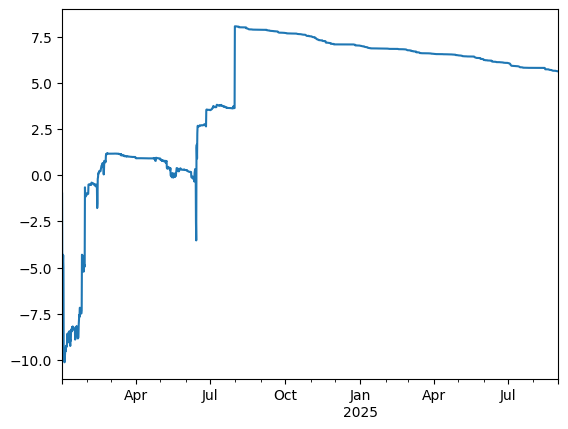

In [98]:
net_returns.apply(lambda x: max(min(x, 5), -5)).cumsum().plot()

In [99]:
get_strategy_stats(net_returns.apply(lambda x: max(min(x, 5), -5)), 8, px.loc[net_returns.index])

{'avg returns': 3.376085384465845,
 'decorrelated avg returns': 3.8727555323718312,
 'volatility': 9.46711126545634,
 'sharpe ratio': 0.3566119896345286,
 'decorrelated sharpe ratio': 0.41034162963843296,
 'max drawdown': -3.954651326448978,
 'max drawdown duration': 395.6666666666667,
 'alpha_BTC': 0.005939764928083956,
 'beta_BTC': 0.7414734906941373}

# Trade Freq = 8h
# Calculate Z-Scores During 2022-2025
# Entry Z-Score = 2.00, Exit Z-Score = 0.75
# Beta calculation window = 3 * 7 * 2
# Z-score calculation window = 3 * 7 * 8

In [102]:
beta_calculation_window = 3 * 7 * 2
z_score_avg_calculation_window = 3 * 7 * 8

start_2022_time = datetime(2022, 1, 1, 0, 0)
start_time = datetime(2024, 1, 1, 0, 0)
end_time = px.index[-1]
px_2022_8h = px.loc[pd.date_range(start_2022_time, end_time, freq='8h').drop(datetime(2023, 2, 6, 8, 0))]
px_2024_8h = px.loc[pd.date_range(start_time, end_time, freq='8h')]

coint_pairs_to_balance = dict()
position_size_changes = dict()

for index, (coin_1, coin_2, z_score) in enumerate(pairs):
    strat_data = calculate_spread_strat_data(
        px_2022_8h,
        coin_1,
        coin_2,
        beta_calculation_window,
        z_score_avg_calculation_window
    )

    single_pair_gross_balance, single_pair_position_size_changes = simulate_trades(
        px_2024_8h, strat_data.loc[start_time:], coin_1, coin_2, 2.00, 0.75)
    coint_pairs_to_balance[(coin_1, coin_2)] = single_pair_gross_balance

    for coin in (coin_1, coin_2):
        if coin in position_size_changes:
            position_size_changes[coin] = position_size_changes[coin] + single_pair_position_size_changes[coin]
        else:
            position_size_changes[coin] = single_pair_position_size_changes[coin]

    print(f"{index+1} / {len(pairs)}")

total_gross_positions = sum(coint_pairs_to_balance.values())

raw_gross_returns = total_gross_positions / total_gross_positions.shift() - 1
gross_returns = raw_gross_returns[~(
    np.isnan(raw_gross_returns) | (raw_gross_returns == float('inf')) | (raw_gross_returns == float('-inf'))
)]

position_size_changes_df = pd.DataFrame(position_size_changes)
turnover = position_size_changes_df.loc[gross_returns.index].abs().sum(axis=1)
tcost_bps = 20
net_returns = gross_returns.subtract(turnover * tcost_bps * 1e-4, fill_value = 0)
stats = get_strategy_stats(net_returns, 8, px.loc[net_returns.index])

1 / 75
2 / 75
3 / 75
4 / 75
5 / 75
6 / 75
7 / 75
8 / 75
9 / 75
10 / 75
11 / 75
12 / 75
13 / 75
14 / 75
15 / 75
16 / 75
17 / 75
18 / 75
19 / 75
20 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


21 / 75
22 / 75
23 / 75
24 / 75
25 / 75
26 / 75
27 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1

28 / 75
29 / 75
30 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


31 / 75
32 / 75
33 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


34 / 75
35 / 75
36 / 75
37 / 75
38 / 75
39 / 75
40 / 75
41 / 75
42 / 75
43 / 75
44 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


45 / 75
46 / 75
47 / 75
48 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


49 / 75
50 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


51 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


52 / 75
53 / 75
54 / 75
55 / 75
56 / 75
57 / 75
58 / 75
59 / 75
60 / 75
61 / 75
62 / 75
63 / 75
64 / 75
65 / 75
66 / 75
67 / 75
68 / 75
69 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


70 / 75
71 / 75
72 / 75
73 / 75
74 / 75
75 / 75


In [103]:
stats

{'avg returns': -2.7636276438573226,
 'decorrelated avg returns': -4.396204994570983,
 'volatility': 28.94967561196518,
 'sharpe ratio': -0.0954631644547716,
 'decorrelated sharpe ratio': -0.15211336230355202,
 'max drawdown': -1.3903630385198689,
 'max drawdown duration': 571.3333333333334,
 'alpha_BTC': -0.014335375842971555,
 'beta_BTC': 0.7933345024506795}

In [104]:
net_returns

2024-01-01 16:00:00    -1.009280
2024-01-02 00:00:00    21.675068
2024-01-02 08:00:00     1.594321
2024-01-02 16:00:00    -0.452184
2024-01-03 00:00:00     0.401635
                         ...    
2025-08-30 00:00:00    -0.001339
2025-08-30 08:00:00    -0.000311
2025-08-30 16:00:00    -0.003982
2025-08-31 00:00:00    -0.001867
2025-08-31 08:00:00     0.000079
Length: 1824, dtype: float64

<Axes: >

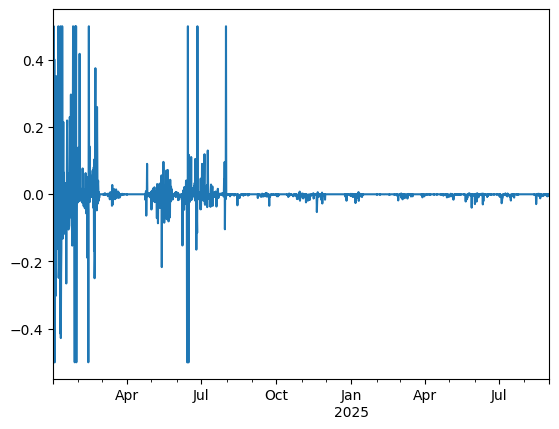

In [109]:
net_returns.apply(lambda x: max(min(x, 0.5), -0.5)).plot()

# Trade Freq = 8h
# Calculate Z-Scores During 2022-2025
# Entry Z-Score = 1.50, Exit Z-Score = 0.75
# Beta calculation window = 3 * 7 * 2
# Z-score calculation window = 3 * 7 * 8

In [110]:
beta_calculation_window = 3 * 7 * 2
z_score_avg_calculation_window = 3 * 7 * 8

start_2022_time = datetime(2022, 1, 1, 0, 0)
start_time = datetime(2024, 1, 1, 0, 0)
end_time = px.index[-1]
px_2022_8h = px.loc[pd.date_range(start_2022_time, end_time, freq='8h').drop(datetime(2023, 2, 6, 8, 0))]
px_2024_8h = px.loc[pd.date_range(start_time, end_time, freq='8h')]

coint_pairs_to_balance = dict()
position_size_changes = dict()

for index, (coin_1, coin_2, z_score) in enumerate(pairs):
    strat_data = calculate_spread_strat_data(
        px_2022_8h,
        coin_1,
        coin_2,
        beta_calculation_window,
        z_score_avg_calculation_window
    )

    single_pair_gross_balance, single_pair_position_size_changes = simulate_trades(
        px_2024_8h, strat_data.loc[start_time:], coin_1, coin_2, 1.50, 0.75)
    coint_pairs_to_balance[(coin_1, coin_2)] = single_pair_gross_balance

    for coin in (coin_1, coin_2):
        if coin in position_size_changes:
            position_size_changes[coin] = position_size_changes[coin] + single_pair_position_size_changes[coin]
        else:
            position_size_changes[coin] = single_pair_position_size_changes[coin]

    print(f"{index+1} / {len(pairs)}")

total_gross_positions = sum(coint_pairs_to_balance.values())

raw_gross_returns = total_gross_positions / total_gross_positions.shift() - 1
gross_returns = raw_gross_returns[~(
    np.isnan(raw_gross_returns) | (raw_gross_returns == float('inf')) | (raw_gross_returns == float('-inf'))
)]

position_size_changes_df = pd.DataFrame(position_size_changes)
turnover = position_size_changes_df.loc[gross_returns.index].abs().sum(axis=1)
tcost_bps = 20
net_returns = gross_returns.subtract(turnover * tcost_bps * 1e-4, fill_value = 0)
stats = get_strategy_stats(net_returns, 8, px.loc[net_returns.index])

1 / 75
2 / 75
3 / 75
4 / 75
5 / 75
6 / 75
7 / 75
8 / 75
9 / 75
10 / 75
11 / 75
12 / 75
13 / 75
14 / 75
15 / 75
16 / 75
17 / 75
18 / 75
19 / 75
20 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


21 / 75
22 / 75
23 / 75
24 / 75
25 / 75
26 / 75
27 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1

28 / 75
29 / 75
30 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


31 / 75
32 / 75
33 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


34 / 75
35 / 75
36 / 75
37 / 75
38 / 75
39 / 75
40 / 75
41 / 75
42 / 75
43 / 75
44 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


45 / 75
46 / 75
47 / 75
48 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


49 / 75
50 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


51 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


52 / 75
53 / 75
54 / 75
55 / 75
56 / 75
57 / 75
58 / 75
59 / 75
60 / 75
61 / 75
62 / 75
63 / 75
64 / 75
65 / 75
66 / 75
67 / 75
68 / 75
69 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


70 / 75
71 / 75
72 / 75
73 / 75
74 / 75
75 / 75


In [112]:
stats

{'avg returns': -1.9887444770039429,
 'decorrelated avg returns': -1.1251004655889936,
 'volatility': 14.23821939860198,
 'sharpe ratio': -0.1396764877214361,
 'decorrelated sharpe ratio': -0.07911516211573284,
 'max drawdown': 0.0,
 'max drawdown duration': 395.6666666666667,
 'alpha_BTC': 0.0012572006713250736,
 'beta_BTC': 0.13592390481554126}

# Trade Freq = 8h
# Calculate Z-Scores During 2022-2025
# Entry Z-Score = 1.75, Exit Z-Score = 0.75
# Beta calculation window = 3 * 7 * 4
# Z-score calculation window = 3 * 7 * 16

In [113]:
beta_calculation_window = 3 * 7 * 4
z_score_avg_calculation_window = 3 * 7 * 16

start_2022_time = datetime(2022, 1, 1, 0, 0)
start_time = datetime(2024, 1, 1, 0, 0)
end_time = px.index[-1]
px_2022_8h = px.loc[pd.date_range(start_2022_time, end_time, freq='8h').drop(datetime(2023, 2, 6, 8, 0))]
px_2024_8h = px.loc[pd.date_range(start_time, end_time, freq='8h')]

coint_pairs_to_balance = dict()
position_size_changes = dict()

for index, (coin_1, coin_2, z_score) in enumerate(pairs):
    strat_data = calculate_spread_strat_data(
        px_2022_8h,
        coin_1,
        coin_2,
        beta_calculation_window,
        z_score_avg_calculation_window
    )

    single_pair_gross_balance, single_pair_position_size_changes = simulate_trades(
        px_2024_8h, strat_data.loc[start_time:], coin_1, coin_2)
    coint_pairs_to_balance[(coin_1, coin_2)] = single_pair_gross_balance

    for coin in (coin_1, coin_2):
        if coin in position_size_changes:
            position_size_changes[coin] = position_size_changes[coin] + single_pair_position_size_changes[coin]
        else:
            position_size_changes[coin] = single_pair_position_size_changes[coin]

    print(f"{index+1} / {len(pairs)}")

total_gross_positions = sum(coint_pairs_to_balance.values())

raw_gross_returns = total_gross_positions / total_gross_positions.shift() - 1
gross_returns = raw_gross_returns[~(
    np.isnan(raw_gross_returns) | (raw_gross_returns == float('inf')) | (raw_gross_returns == float('-inf'))
)]

position_size_changes_df = pd.DataFrame(position_size_changes)
turnover = position_size_changes_df.loc[gross_returns.index].abs().sum(axis=1)
tcost_bps = 20
net_returns = gross_returns.subtract(turnover * tcost_bps * 1e-4, fill_value = 0)
stats = get_strategy_stats(net_returns, 8, px.loc[net_returns.index])

1 / 75
2 / 75
3 / 75
4 / 75
5 / 75
6 / 75
7 / 75
8 / 75
9 / 75
10 / 75
11 / 75
12 / 75
13 / 75
14 / 75
15 / 75
16 / 75
17 / 75
18 / 75
19 / 75
20 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


21 / 75
22 / 75
23 / 75
24 / 75
25 / 75
26 / 75
27 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


28 / 75
29 / 75
30 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


31 / 75
32 / 75
33 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


34 / 75
35 / 75
36 / 75
37 / 75
38 / 75
39 / 75
40 / 75
41 / 75
42 / 75
43 / 75
44 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


45 / 75
46 / 75
47 / 75
48 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


49 / 75
50 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


51 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


52 / 75
53 / 75
54 / 75
55 / 75
56 / 75
57 / 75
58 / 75
59 / 75
60 / 75
61 / 75
62 / 75
63 / 75
64 / 75
65 / 75
66 / 75
67 / 75
68 / 75
69 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


70 / 75
71 / 75
72 / 75
73 / 75
74 / 75
75 / 75


In [114]:
stats

{'avg returns': 9.11104167365553,
 'decorrelated avg returns': 9.011140395394035,
 'volatility': 18.128568243042118,
 'sharpe ratio': 0.5025792192470808,
 'decorrelated sharpe ratio': 0.4974085905607078,
 'max drawdown': -1.630592165560293,
 'max drawdown duration': 396.0,
 'alpha_BTC': 0.00813313623800639,
 'beta_BTC': 0.882253563073365}

# Trade Freq = 8h
# Calculate Z-Scores During 2022-2025
# Entry Z-Score = 1.75, Exit Z-Score = 0.75
# Beta calculation window = 3 * 7 * 8
# Z-score calculation window = 3 * 7 * 16

In [115]:
beta_calculation_window = 3 * 7 * 8
z_score_avg_calculation_window = 3 * 7 * 16

start_2022_time = datetime(2022, 1, 1, 0, 0)
start_time = datetime(2024, 1, 1, 0, 0)
end_time = px.index[-1]
px_2022_8h = px.loc[pd.date_range(start_2022_time, end_time, freq='8h').drop(datetime(2023, 2, 6, 8, 0))]
px_2024_8h = px.loc[pd.date_range(start_time, end_time, freq='8h')]

coint_pairs_to_balance = dict()
position_size_changes = dict()

for index, (coin_1, coin_2, z_score) in enumerate(pairs):
    strat_data = calculate_spread_strat_data(
        px_2022_8h,
        coin_1,
        coin_2,
        beta_calculation_window,
        z_score_avg_calculation_window
    )

    single_pair_gross_balance, single_pair_position_size_changes = simulate_trades(
        px_2024_8h, strat_data.loc[start_time:], coin_1, coin_2)
    coint_pairs_to_balance[(coin_1, coin_2)] = single_pair_gross_balance

    for coin in (coin_1, coin_2):
        if coin in position_size_changes:
            position_size_changes[coin] = position_size_changes[coin] + single_pair_position_size_changes[coin]
        else:
            position_size_changes[coin] = single_pair_position_size_changes[coin]

    print(f"{index+1} / {len(pairs)}")

total_gross_positions = sum(coint_pairs_to_balance.values())

raw_gross_returns = total_gross_positions / total_gross_positions.shift() - 1
gross_returns = raw_gross_returns[~(
    np.isnan(raw_gross_returns) | (raw_gross_returns == float('inf')) | (raw_gross_returns == float('-inf'))
)]

position_size_changes_df = pd.DataFrame(position_size_changes)
turnover = position_size_changes_df.loc[gross_returns.index].abs().sum(axis=1)
tcost_bps = 20
net_returns = gross_returns.subtract(turnover * tcost_bps * 1e-4, fill_value = 0)
stats = get_strategy_stats(net_returns, 8, px.loc[net_returns.index])

1 / 75
2 / 75
3 / 75
4 / 75
5 / 75
6 / 75
7 / 75
8 / 75
9 / 75
10 / 75
11 / 75
12 / 75
13 / 75
14 / 75
15 / 75
16 / 75
17 / 75
18 / 75
19 / 75
20 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


21 / 75
22 / 75
23 / 75
24 / 75
25 / 75
26 / 75
27 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


28 / 75
29 / 75
30 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


31 / 75
32 / 75
33 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


34 / 75
35 / 75
36 / 75
37 / 75
38 / 75
39 / 75
40 / 75
41 / 75
42 / 75
43 / 75
44 / 75
45 / 75
46 / 75
47 / 75
48 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


49 / 75
50 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


51 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


52 / 75
53 / 75
54 / 75
55 / 75
56 / 75
57 / 75
58 / 75
59 / 75
60 / 75
61 / 75
62 / 75
63 / 75
64 / 75
65 / 75
66 / 75
67 / 75
68 / 75
69 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


70 / 75
71 / 75
72 / 75
73 / 75
74 / 75
75 / 75


In [116]:
stats

{'avg returns': 12.676313036337648,
 'decorrelated avg returns': 13.547924317598953,
 'volatility': 17.87157020135916,
 'sharpe ratio': 0.7093004640058767,
 'decorrelated sharpe ratio': 0.7583726500787712,
 'max drawdown': -3.2374095831526803,
 'max drawdown duration': 396.0,
 'alpha_BTC': 0.01242886695658209,
 'beta_BTC': -0.6184489060717117}

# Trade Freq = 8h
# Calculate Z-Scores During 2022-2025
# Entry Z-Score = 1.75, Exit Z-Score = 0.75
# Beta calculation window = 3 * 7 * 16
# Z-score calculation window = 3 * 7 * 16

In [117]:
beta_calculation_window = 3 * 7 * 16
z_score_avg_calculation_window = 3 * 7 * 16

start_2022_time = datetime(2022, 1, 1, 0, 0)
start_time = datetime(2024, 1, 1, 0, 0)
end_time = px.index[-1]
px_2022_8h = px.loc[pd.date_range(start_2022_time, end_time, freq='8h').drop(datetime(2023, 2, 6, 8, 0))]
px_2024_8h = px.loc[pd.date_range(start_time, end_time, freq='8h')]

coint_pairs_to_balance = dict()
position_size_changes = dict()

for index, (coin_1, coin_2, z_score) in enumerate(pairs):
    strat_data = calculate_spread_strat_data(
        px_2022_8h,
        coin_1,
        coin_2,
        beta_calculation_window,
        z_score_avg_calculation_window
    )

    single_pair_gross_balance, single_pair_position_size_changes = simulate_trades(
        px_2024_8h, strat_data.loc[start_time:], coin_1, coin_2)
    coint_pairs_to_balance[(coin_1, coin_2)] = single_pair_gross_balance

    for coin in (coin_1, coin_2):
        if coin in position_size_changes:
            position_size_changes[coin] = position_size_changes[coin] + single_pair_position_size_changes[coin]
        else:
            position_size_changes[coin] = single_pair_position_size_changes[coin]

    print(f"{index+1} / {len(pairs)}")

total_gross_positions = sum(coint_pairs_to_balance.values())

raw_gross_returns = total_gross_positions / total_gross_positions.shift() - 1
gross_returns = raw_gross_returns[~(
    np.isnan(raw_gross_returns) | (raw_gross_returns == float('inf')) | (raw_gross_returns == float('-inf'))
)]

position_size_changes_df = pd.DataFrame(position_size_changes)
turnover = position_size_changes_df.loc[gross_returns.index].abs().sum(axis=1)
tcost_bps = 20
net_returns = gross_returns.subtract(turnover * tcost_bps * 1e-4, fill_value = 0)
stats = get_strategy_stats(net_returns, 8, px.loc[net_returns.index])

1 / 75
2 / 75
3 / 75
4 / 75
5 / 75
6 / 75
7 / 75
8 / 75
9 / 75
10 / 75
11 / 75
12 / 75
13 / 75
14 / 75
15 / 75
16 / 75
17 / 75
18 / 75
19 / 75
20 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


21 / 75
22 / 75
23 / 75
24 / 75
25 / 75
26 / 75
27 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


28 / 75
29 / 75
30 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


31 / 75
32 / 75
33 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


34 / 75
35 / 75
36 / 75
37 / 75
38 / 75
39 / 75
40 / 75
41 / 75
42 / 75
43 / 75
44 / 75
45 / 75
46 / 75
47 / 75
48 / 75
49 / 75
50 / 75
51 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


52 / 75
53 / 75
54 / 75
55 / 75
56 / 75
57 / 75
58 / 75
59 / 75
60 / 75
61 / 75
62 / 75
63 / 75
64 / 75
65 / 75
66 / 75
67 / 75
68 / 75
69 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


70 / 75
71 / 75
72 / 75
73 / 75
74 / 75
75 / 75


In [118]:
stats

{'avg returns': -136.32134595231838,
 'decorrelated avg returns': -136.8612151934616,
 'volatility': 158.07989781751564,
 'sharpe ratio': -0.8623572499375289,
 'decorrelated sharpe ratio': -0.8655443252856108,
 'max drawdown': -124.60769840858951,
 'max drawdown duration': 605.6666666666666,
 'alpha_BTC': -0.12509101223095473,
 'beta_BTC': 1.2368057115079956}

<Axes: >

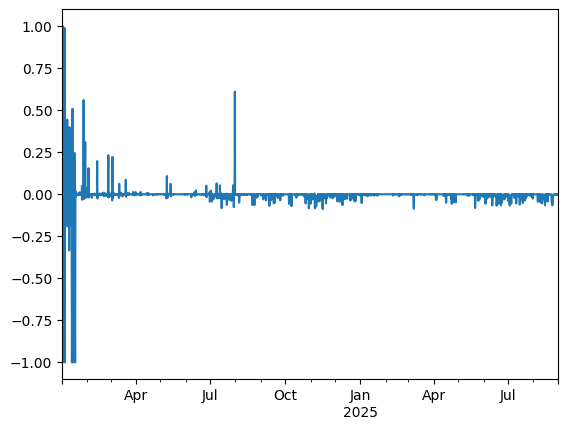

In [121]:
net_returns.apply(lambda x: max(min(x, 1.0), -1.0)).plot()

# Trade Freq = 8h
# Calculate Z-Scores During 2022-2025
# Entry Z-Score = 1.75, Exit Z-Score = 0.75
# Beta calculation window = 3 * 7 * 16
# Z-score calculation window = 3 * 7 * 32

In [122]:
beta_calculation_window = 3 * 7 * 16
z_score_avg_calculation_window = 3 * 7 * 32

start_2022_time = datetime(2022, 1, 1, 0, 0)
start_time = datetime(2024, 1, 1, 0, 0)
end_time = px.index[-1]
px_2022_8h = px.loc[pd.date_range(start_2022_time, end_time, freq='8h').drop(datetime(2023, 2, 6, 8, 0))]
px_2024_8h = px.loc[pd.date_range(start_time, end_time, freq='8h')]

coint_pairs_to_balance = dict()
position_size_changes = dict()

for index, (coin_1, coin_2, z_score) in enumerate(pairs):
    strat_data = calculate_spread_strat_data(
        px_2022_8h,
        coin_1,
        coin_2,
        beta_calculation_window,
        z_score_avg_calculation_window
    )

    single_pair_gross_balance, single_pair_position_size_changes = simulate_trades(
        px_2024_8h, strat_data.loc[start_time:], coin_1, coin_2)
    coint_pairs_to_balance[(coin_1, coin_2)] = single_pair_gross_balance

    for coin in (coin_1, coin_2):
        if coin in position_size_changes:
            position_size_changes[coin] = position_size_changes[coin] + single_pair_position_size_changes[coin]
        else:
            position_size_changes[coin] = single_pair_position_size_changes[coin]

    print(f"{index+1} / {len(pairs)}")

total_gross_positions = sum(coint_pairs_to_balance.values())

raw_gross_returns = total_gross_positions / total_gross_positions.shift() - 1
gross_returns = raw_gross_returns[~(
    np.isnan(raw_gross_returns) | (raw_gross_returns == float('inf')) | (raw_gross_returns == float('-inf'))
)]

position_size_changes_df = pd.DataFrame(position_size_changes)
turnover = position_size_changes_df.loc[gross_returns.index].abs().sum(axis=1)
tcost_bps = 20
net_returns = gross_returns.subtract(turnover * tcost_bps * 1e-4, fill_value = 0)
stats = get_strategy_stats(net_returns, 8, px.loc[net_returns.index])

1 / 75
2 / 75
3 / 75
4 / 75
5 / 75
6 / 75
7 / 75
8 / 75
9 / 75
10 / 75
11 / 75
12 / 75
13 / 75
14 / 75
15 / 75
16 / 75
17 / 75
18 / 75
19 / 75
20 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


21 / 75
22 / 75
23 / 75
24 / 75
25 / 75
26 / 75
27 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


28 / 75
29 / 75
30 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


31 / 75
32 / 75
33 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()
/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


34 / 75
35 / 75
36 / 75
37 / 75
38 / 75
39 / 75
40 / 75
41 / 75
42 / 75
43 / 75
44 / 75
45 / 75
46 / 75
47 / 75
48 / 75
49 / 75
50 / 75
51 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


52 / 75
53 / 75
54 / 75
55 / 75
56 / 75
57 / 75
58 / 75
59 / 75
60 / 75
61 / 75
62 / 75
63 / 75
64 / 75
65 / 75
66 / 75
67 / 75
68 / 75
69 / 75


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_2440/1739597316.py:16: RuntimeWarning: invalid value encountered in scalar divide
  beta = calculated_cov / coin_2_prices.var()


70 / 75
71 / 75
72 / 75
73 / 75
74 / 75
75 / 75


In [123]:
stats

{'avg returns': -13.160476926468807,
 'decorrelated avg returns': -13.613086224661943,
 'volatility': 30.952612498975625,
 'sharpe ratio': -0.4251814584925377,
 'decorrelated sharpe ratio': -0.4398142021397617,
 'max drawdown': -191.0684713328778,
 'max drawdown duration': 606.3333333333334,
 'alpha_BTC': -0.012404968277363612,
 'beta_BTC': 1.2165327164739619}